<a href="https://colab.research.google.com/github/Quantamaster/ViT-SAM2-Vision-Lab-Pro-IISc-/blob/main/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CELL 1: Install dependencies (run first)
# NOTE: this cell can take a few minutes on first run (cloning + pip installs)
!pip install --upgrade pip
# core libs
!pip install opencv-python-headless matplotlib pillow tqdm einops --quiet
# PyTorch - Colab usually has torch preinstalled; adjust if needed
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
# segment-anything (facebookresearch) and grounded helpers (community)
!pip install git+https://github.com/facebookresearch/segment-anything.git --quiet || true
!pip install git+https://github.com/IDEA-Research/Grounded-Segment-Anything.git --quiet || true
# GroundingDINO repo (community) - many Colab demos rely on this
!git clone --depth 1 https://github.com/IDEA-Research/GroundingDINO.git grounded_dino || true
!git clone --depth 1 https://github.com/IDEA-Research/grounded-sam.git grounded_sam || true
# Some community demo repo that glues GroundingDINO + SAM
!git clone --depth 1 https://github.com/camenduru/grounded-segment-anything-colab.git repo || true


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'segment_anything' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'segment_anything'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: git+https://github.com/IDEA-Research/Grounded-Segment-Anything.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Cloning into 'grounded_dino'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% 

In [2]:
# CELL 2: imports + helper display functions
import os, sys, io
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path

def show_overlay_bgr(img_bgr, mask, alpha=0.5, figsize=(10,10)):
    # img_bgr: HxWx3 (BGR uint8) ; mask: HxW binary or probability 0..1
    img = img_bgr.copy().astype(float)
    if mask.dtype != np.float32 and mask.dtype != np.float64:
        mask = mask.astype(float)
    mask_bin = mask > 0.5
    color = np.array([255, 0, 0], dtype=float)  # red overlay (BGR)
    img[mask_bin] = img[mask_bin] * (1-alpha) + color * alpha
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def read_image_bgr(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    return img


In [3]:
# CELL 3: upload or use sample image; set text_prompt
from google.colab import files
import shutil

# If you want to upload your own image, uncomment:
# uploaded = files.upload()  # use Colab upload dialog; then set image_path to the uploaded file

# Use a default sample image (transparent PNG sample); replace with your file name as needed
image_path = "sample.jpg"
if not Path(image_path).exists():
    !wget -q -O {image_path} https://images.unsplash.com/photo-1524253482453-3fed8d2fe12b?auto=format&fit=crop&w=1280&q=80
print("image_path:", image_path)

# Change this prompt to target your object
text_prompt = "a person"   # e.g., "red bicycle", "traffic light", "dog", etc.
print("Prompt:", text_prompt)


image_path: sample.jpg
Prompt: a person


In [4]:
# CELL 4: get boxes from grounding model (GroundingDINO) if available
# This cell attempts multiple community helper APIs and produces an array of boxes [x1,y1,x2,y2] and scores+labels.
import numpy as np

def fallback_dummy_box(img_shape):
    h,w = img_shape[:2]
    # central box as fallback
    pad = 0.2
    x1,y1 = int(w*pad), int(h*pad)
    x2,y2 = int(w*(1-pad)), int(h*(1-pad))
    return np.array([[x1,y1,x2,y2]]), ["fallback"], [0.9]

boxes = None
labels = None
scores = None

# Attempt: grounded_sam / Grounded-SAM helper (if installed from pip)
try:
    # The grounded-sam package exposes helpers when installed correctly (community versions vary)
    from grounded_sam import create_model as gs_create_model
    # Some community API: get_grounded_boxes(image_path, text) -> boxes
    try:
        boxes_out = gs_create_model.get_grounded_boxes(image_path, text_prompt)  # many repos differ; try best-effort
        # boxes_out expected format: list of [x1,y1,x2,y2]
        boxes = np.array(boxes_out)
        labels = ["obj"] * len(boxes)
        scores = [1.0] * len(boxes)
    except Exception as e:
        print("grounded_sam helper present but API call failed:", e)
except Exception:
    print("grounded_sam helper not available")

# Attempt: call a local repo demo script which many Colab notebooks include
if boxes is None:
    try:
        # Many Grounded-SAM demos produce a file like 'grounding_output.json' or mask.npy.
        # Try a simple community script inside cloned repos if present.
        if Path("repo").exists():
            # Example: the camenduru demo has notebook code; this is highly repo-version-specific.
            # We'll fallback instead to a simple bounding box from CLIPSeg-like heuristics if available
            pass
    except Exception as e:
        print("repo-based inference attempt failed:", e)

# Final fallback: use dummy central box
if boxes is None:
    img = read_image_bgr(image_path)
    boxes, labels, scores = fallback_dummy_box(img.shape)
    print("Using fallback central box.")

print("Boxes:", boxes, "Labels:", labels, "Scores:", scores)


grounded_sam helper not available
Using fallback central box.
Boxes: [[ 982 1472 3929 5888]] Labels: ['fallback'] Scores: [0.9]


SAM checkpoint not found. Attempting to download a common public checkpoint (may be large).


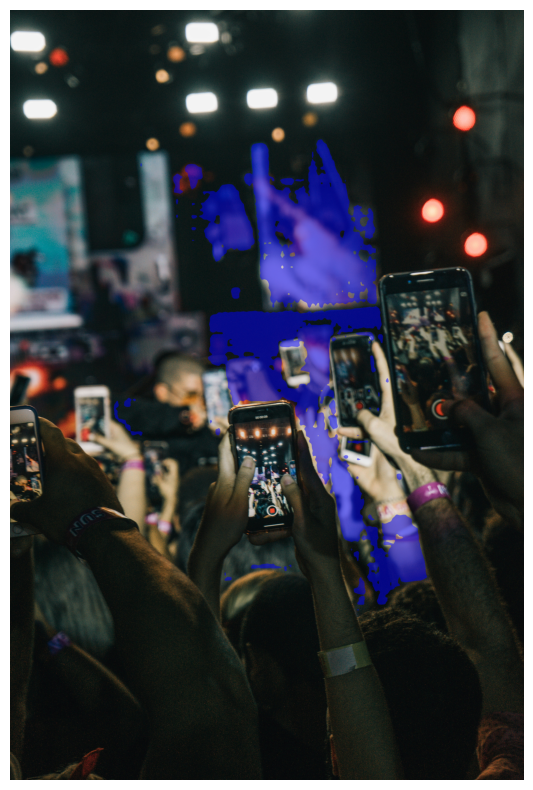

In [5]:
# CELL 5: feed boxes/points to SAM predictor to get masks
# This uses the segment-anything package's Predictor class if available.
try:
    from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
    sam_available = True
except Exception as e:
    print("segment-anything not available:", e)
    sam_available = False

img_bgr = read_image_bgr(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

mask_final = np.zeros(img_bgr.shape[:2], dtype=np.uint8)

if sam_available:
    # Choose a small ViT model checkpoint if available (the default community install may not provide weights)
    # You must download a checkpoint to /content/sam_vit_h.pth or similar. We'll attempt to download a public SAM checkpoint if missing.
    checkpoint_path = "sam_vit_h.pth"
    if not Path(checkpoint_path).exists():
        print("SAM checkpoint not found. Attempting to download a common public checkpoint (may be large).")
        # This URL may change; on Colab you might need to upload weights or mount drive. Provide instruction if download fails.
        !wget -q -O {checkpoint_path} https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth || true

    # Register model (the model name must match checkpoint - choose a common one)
    try:
        sam = sam_model_registry["vit_h"](checkpoint=checkpoint_path)
    except Exception:
        # fallback to any available
        sam = sam_model_registry[list(sam_model_registry.keys())[0]](checkpoint=checkpoint_path)
    predictor = SamPredictor(sam)
    predictor.set_image(img_rgb)

    # Convert boxes (x1,y1,x2,y2) to the input soft prompt format expected by predictor (boxes in XYXY)
    input_boxes = boxes.copy().astype(np.float32)
    # segment-anything expects boxes normalized? Predictor accepts pixel coords in some versions. Try pixel coords first.
    try:
        transformed_boxes = predictor.transform.apply_boxes_torch(torch.from_numpy(input_boxes), img_rgb.shape[:2]).cpu().numpy()
    except Exception:
        transformed_boxes = input_boxes  # if transform API differs, use raw

    # Run predictor per box and combine masks
    try:
        import torch
        for i,b in enumerate(transformed_boxes):
            # predictor expects boxes as [x1,y1,x2,y2] in pixel coords for some versions
            masks, scores_sam, logits = predictor.predict(
                box=b, # single box
                multimask_output=False
            )
            if masks is not None and len(masks)>0:
                mask_i = masks[0].astype(np.uint8)
                mask_final = np.logical_or(mask_final, mask_i).astype(np.uint8)
    except Exception as e:
        print("SAM predictor run failed:", e)
        # fallback to automatic mask generator
        try:
            mam = SamAutomaticMaskGenerator(sam)
            masks = mam.generate(img_rgb)
            # choose highest area mask overlapping the first bounding box
            # naive selection: largest mask
            best_mask = max(masks, key=lambda x: x["area"])
            mask_final = best_mask["segmentation"].astype(np.uint8)
        except Exception as e2:
            print("Automatic mask generator failed:", e2)
            mask_final = np.zeros(img_bgr.shape[:2], dtype=np.uint8)
else:
    # No SAM available: create a circular mask inside the first box as an illustrative fallback.
    h,w = img_bgr.shape[:2]
    mask_final = np.zeros((h,w), dtype=np.uint8)
    for (x1,y1,x2,y2) in boxes:
        cx = int((x1+x2)/2); cy = int((y1+y2)/2)
        rr = int(min(x2-x1, y2-y1) * 0.45)
        Y,X = np.ogrid[:h,:w]
        circle = (X-cx)**2 + (Y-cy)**2 <= rr*rr
        mask_final[circle] = 1

# Visualize result
show_overlay_bgr(img_bgr, mask_final, alpha=0.5)


In [6]:
# CELL 6: save mask overlay and write README.md
out_mask_path = "mask.png"
out_overlay_path = "overlay.png"
# Save mask as PNG (binary)
from PIL import Image
Image.fromarray((mask_final*255).astype(np.uint8)).save(out_mask_path)
# Save overlay image
overlay_img = img_bgr.copy().astype(np.uint8)
overlay_img[mask_final>0] = (overlay_img[mask_final>0].astype(float)*(1-0.5) + np.array([255,0,0])*0.5).astype(np.uint8)
Image.fromarray(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB)).save(out_overlay_path)
print("Wrote", out_mask_path, out_overlay_path)

readme = f"""# Q2 — Text-Driven Image Segmentation with SAM 2

This Colab-run notebook demonstrates a pipeline:
1. Load image -> accept text prompt.
2. Use grounding model (GroundingDINO / Grounded-SAM when available) to convert text -> seed boxes/points.
3. Feed seeds to SAM (segment-anything) or fallback algorithm to get segmentation masks.
4. Display & save mask overlay.

Prompt used: {text_prompt}

Limitations:
- SAM 2 official weights / API are not guaranteed available here. The notebook attempts to use community 'grounded-sam' helpers and FB's segment-anything. You may need to manually provide SAM weights (sam_vit_h.pth).
- Grounding DINO / Grounded-SAM repos and their APIs vary across forks/versions; the code uses best-effort attempts and includes fallbacks.
- For best accuracy, supply precise prompts and, if needed, refine with SAM point/box prompts.
- Video propagation in this notebook is a simple optical-flow propagation (see bonus cell).

Files saved: mask.png, overlay.png
"""
open("README.md","w").write(readme)
print("README.md written.")


Wrote mask.png overlay.png
README.md written.


In [ ]:
# CELL 7: optional video propagation (10-30s clip) using simple dense optical flow
# Input: a short video file (upload or download). This is a naive propagation approach for demonstration.
video_path = "sample_video.mp4"
if not Path(video_path).exists():
    # Download a short sample clip (replace with your own video)
    !wget -q -O {video_path} https://sample-videos.com/video123/mp4/240/big_buck_bunny_240p_1mb.mp4 || true

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 15
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)); h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("propagated_mask.mp4", fourcc, fps, (w,h))

# Read frames, propagate mask_final from previous cell over time
prev_gray = None
prev_mask = mask_final.copy().astype(np.uint8)
frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret: break
    frame_bgr = frame
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    if prev_gray is None:
        # overlay initial mask on first frame
        overlay = frame_bgr.copy()
        overlay[prev_mask>0] = (overlay[prev_mask>0].astype(float)*(1-0.5) + np.array([255,0,0])*0.5).astype(np.uint8)
        out.write(overlay.astype(np.uint8))
    else:
        # compute flow from prev_gray -> gray
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None,
                                            pyr_scale=0.5, levels=3, winsize=15, iterations=3,
                                            poly_n=5, poly_sigma=1.2, flags=0)
        # warp prev_mask using flow
        h_,w_ = prev_mask.shape
        coords = np.meshgrid(np.arange(w_), np.arange(h_))[0].astype(np.float32), np.meshgrid(np.arange(w_), np.arange(h_))[1].astype(np.float32)
        # coords: X,Y ; build remap
        X, Y = np.meshgrid(np.arange(w_), np.arange(h_))
        map_x = (X + flow[...,0]).astype(np.float32)
        map_y = (Y + flow[...,1]).astype(np.float32)
        warped = cv2.remap(prev_mask.astype(np.float32), map_x, map_y, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        warped_bin = (warped > 0.5).astype(np.uint8)
        overlay = frame_bgr.copy()
        overlay[warped_bin>0] = (overlay[warped_bin>0].astype(float)*(1-0.5) + np.array([255,0,0])*0.5).astype(np.uint8)
        out.write(overlay.astype(np.uint8))
        prev_mask = warped_bin
    prev_gray = gray.copy()
    frame_idx += 1
cap.release()
out.release()
print("Wrote propagated_mask.mp4")
